In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
from astropy.stats import funcs

In [2]:
import matplotlib
matplotlib.rcParams.update({'font.size':18})
matplotlib.rcParams.update({'font.family':'serif'})

**The Plan**

- read in KIC 2 TIC reference
- read in Kepler periods from Amy McQuillan's paper
- read all the TESS rot estimates from my script
- combine all TESS rot files
- xmatch TESS to Kepler
- Comparison plot!

In [3]:
tess_dir = '/Users/james/Desktop/helloTESS/outputs/'

# if you want ALL the sectors
rfiles = glob(tess_dir + '*rot_out.csv')

In [4]:
# but, we only want Sectors 14 & 15
rot1 = pd.read_csv(tess_dir + 'sector014_rot_out.csv')
rot2 = pd.read_csv(tess_dir + 'sector015_rot_out.csv')

print(rot1.shape, rot2.shape)

(19993, 12) (19996, 12)


Text(0, 0.5, 'L-S Period (days)')

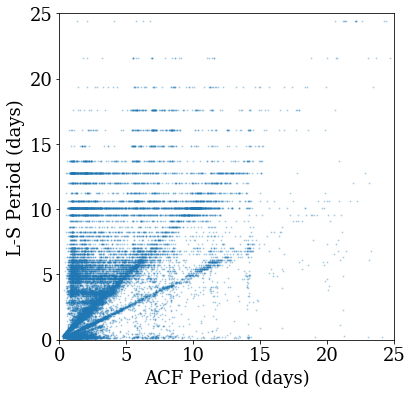

In [5]:
plt.figure(figsize=(6,6))
plt.scatter(rot1['acf_per'],rot1['LSper'], s=1, alpha=0.25)
# plt.scatter(rot2['acf_per'],rot2['LSper'], s=1, alpha=0.25)

plt.xlim(0,25)
plt.ylim(0,25)
plt.xlabel('ACF Period (days)')
plt.ylabel('L-S Period (days)')

In [6]:
KICTIC = pd.read_csv('/Users/james/Dropbox/research_projects/kic2tic/KIC2TIC.csv')

KICTIC.shape

(199421, 2)

In [7]:
rot1.merge(KICTIC, left_on='TIC', right_on='TIC').shape

(1274, 13)

In [8]:
rot2.merge(KICTIC, left_on='TIC', right_on='TIC').shape

(769, 13)

In [9]:
# How many Kepler stars did TESS get short-cadence data for?
pd.concat((rot1.merge(KICTIC, left_on='TIC', right_on='TIC'), 
           rot2.merge(KICTIC, left_on='TIC', right_on='TIC')))['TIC'].unique().size

1359

In [10]:
%%time
from astropy.table import Table
tbl = Table.read('/Users/james/Dropbox/research_projects/kic2tic/stellar17.txt', format='ascii.ipac')
stellar17 = tbl.to_pandas()

/Users/james/opt/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: TableReplaceWarning: converted column 'teff_err1' from integer to float
  exec(code, glob, local_ns)
/Users/james/opt/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: TableReplaceWarning: converted column 'teff_err2' from integer to float
  exec(code, glob, local_ns)
/Users/james/opt/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: TableReplaceWarning: converted column 'timeout01p5' from integer to float
  exec(code, glob, local_ns)
/Users/james/opt/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: TableReplaceWarning: converted column 'timeout02p0' from integer to float
  exec(code, glob, local_ns)
/Users/james/opt/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: TableReplaceWarning: converted column 'timeout02p5' from integer to float
  exec(code, glob, local_ns)
/Users/james/opt/an

CPU times: user 20.7 s, sys: 2.04 s, total: 22.8 s
Wall time: 22.3 s


In [11]:
# stellar17.columns

In [12]:
s17 = pd.DataFrame(data={'kic':stellar17['kepid'], 'kepmag':stellar17['kepmag']})

In [13]:
Kper13 = pd.read_csv('./amq_Period_Table.txt')
Kper14 = pd.read_table('mcquillan2014_tbl1.txt', delim_whitespace=True)
print(Kper13.shape, Kper14.shape)

(1570, 8) (34030, 11)


In [14]:
# Kper13.columns

In [15]:
# Kper14.columns

In [16]:
# Combine McQuillan 2013 & 2014, drop duplicate entries (prefer 2014, I believe)
Kper = pd.concat((Kper14[['KID', 'Period', 'Teff']], 
                  Kper13[['KID', 'Period', 'Teff']])).drop_duplicates(subset='KID')

In [17]:
# add TIC to the Kepler periods
KTper = Kper.merge(KICTIC, left_on='KID', right_on='KIC', how='inner')

KTper.shape

(34154, 5)

In [18]:
KTper = KTper.merge(s17, left_on='KID', right_on='kic', how='inner')
KTper.shape

(34154, 7)

In [19]:
# how many Kepler rotators were in Sector 14?
Trot1 = rot1.merge(KTper, left_on='TIC', right_on='TIC')
Trot1.shape

(169, 18)

In [20]:
# how many Kepler rotators were in Sector 155?
Trot2 = rot2.merge(KTper, left_on='TIC', right_on='TIC')
Trot2.shape

(80, 18)

In [21]:
# how many Kepler rotators were in Sector 14 OR 15?
Trot12 = pd.concat((Trot1, Trot2))

print(Trot12['KIC'].size, Trot12['KIC'].unique().size)

249 178


In [22]:
Trot12

,Unnamed: 0,TIC,LSper,LSamp,LSmed,LSstd,acf_pk,acf_per,bls_per,bls_ampl,ecl_num,ecl_dep,KID,Period,Teff,KIC,kic,kepmag
0,56,164725641,0.118602,0.000994,0.000085,0.000476,0.000377,1.611091,11.089102,1.262927,-1.0,-1.000000,9203794,52.272,3247,9203794,9203794,13.764
1,230,267673296,12.786816,0.011855,0.000091,0.000206,-0.006687,3.693741,-1.000000,-1.000000,-1.0,-1.000000,12555642,39.110,0,12555642,12555642,10.748
2,482,399954267,3.635478,0.423243,0.000094,0.001899,0.306006,7.135371,-1.000000,-1.000000,2.0,-0.505576,11499453,7.288,5810,11499453,11499453,10.658
3,718,351910775,0.879503,0.179061,0.000101,0.000975,0.281266,0.893045,0.890305,31.834498,-1.0,-1.000000,8804962,0.900,6358,8804962,8804962,10.285
4,777,164413746,0.308264,0.030463,0.000201,0.000452,0.017178,0.924290,0.926497,12.693081,-1.0,-1.000000,7662428,4.641,6088,7662428,7662428,9.007
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,18381,240178277,12.523145,0.010031,0.000106,0.000324,0.005662,1.897184,-1.000000,-1.000000,-1.0,-1.000000,9893496,25.235,4964,9893496,9893496,11.500
76,18859,270619467,12.523153,0.026650,0.000126,0.000384,0.011659,3.045079,13.965424,4.462425,-1.0,-1.000000,10016032,5.979,6320,10016032,10016032,10.698
77,18924,172423418,6.174607,0.012501,0.000142,0.001122,-0.022451,7.793572,6.413895,1.384033,-1.0,-1.000000,5567165,34.280,3733,5567165,5567165,13.803
78,19544,270517307,12.523152,0.002311,0.000084,0.000092,-0.000362,3.056190,11.590079,1.539716,-1.0,-1.000000,10079226,15.694,5843,10079226,10079226,10.074


In [25]:
#### dump list out for Tyler to run GP+MCMC on
lc14 = glob('/Users/james/Desktop/tess/sector014/*.fits', recursive=True)
lc15 = glob('/Users/james/Desktop/tess/sector015/*.fits', recursive=True)

lc = pd.Series(lc14 + lc15)
obj = lc.str.split('-', expand=True)[2]

df_join = pd.DataFrame(data={'tic':obj.astype('int'), 'file': lc})

pd.Series(pd.merge(Trot12, df_join, left_on='TIC', right_on='tic', 
                   how='inner')['file'].unique()).to_csv('kep_tess_rot.csv', index=False, index_label=False, header=False)

Text(0, 0.5, 'TESS Period (days)')

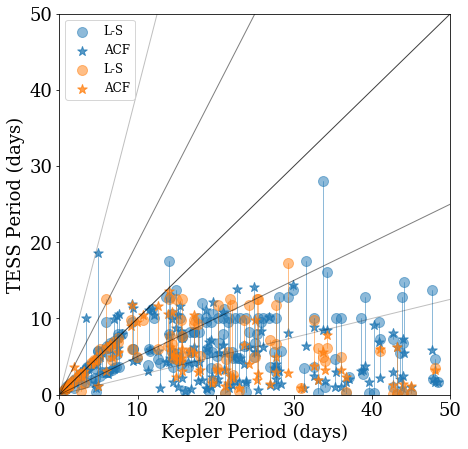

In [22]:
plt.figure(figsize=(7,7))
plt.scatter(Trot1['Period'], Trot1['LSper'], alpha=0.5, c='C0', s=100, label='L-S')
plt.scatter(Trot1['Period'], Trot1['acf_per'], alpha=0.75, c='C0', s=100, marker='*', label='ACF')
for k in range(len(Trot1)):
    plt.plot([Trot1['Period'][k], Trot1['Period'][k]], [Trot1['LSper'][k], Trot1['acf_per'][k]], 
             lw=0.5, c='C0')
    
plt.scatter(Trot2['Period'], Trot2['LSper'], alpha=0.5, c='C1', s=100, label='L-S')
plt.scatter(Trot2['Period'], Trot2['acf_per'], alpha=0.75, c='C1', s=100, marker='*', label='ACF')
for k in range(len(Trot2)):
    plt.plot([Trot2['Period'][k], Trot2['Period'][k]], [Trot2['LSper'][k], Trot2['acf_per'][k]], 
             lw=0.5, c='C1')


plt.plot([.1,50], [.1, 50], c='k', lw=1, alpha=0.75)
plt.plot([.1,50], [.05, 25], c='k', lw=1, alpha=0.5)
plt.plot([.1,50], [.025, 12.5], c='k', lw=1, alpha=0.25)
plt.plot([.1,50], [.2, 100], c='k', lw=1, alpha=0.5)
plt.plot([.1,50], [.4, 200], c='k', lw=1, alpha=0.25)

plt.xlim(0,50)
plt.ylim(0,50)
plt.legend(fontsize=12)

plt.xlabel('Kepler Period (days)')
plt.ylabel('TESS Period (days)')

In [23]:
# pick "good" periods
# this cut is somewhat arbitrary, unfortunately. We need real errors on the periods (e.g. MCMC)
Pcut = 0.05

ok1 = ((Trot1['acf_pk'] > Pcut) | (Trot1['LSamp'] > Pcut)) & (Trot1['Teff'] > 0)
ok2 = ((Trot2['acf_pk'] > Pcut) | (Trot2['LSamp'] > Pcut)) & (Trot2['Teff'] > 0)

print(sum(ok1), sum(ok2))
print(pd.concat((Trot1['KIC'][ok1],Trot2['KIC'][ok2])).unique().size)

74 34
84


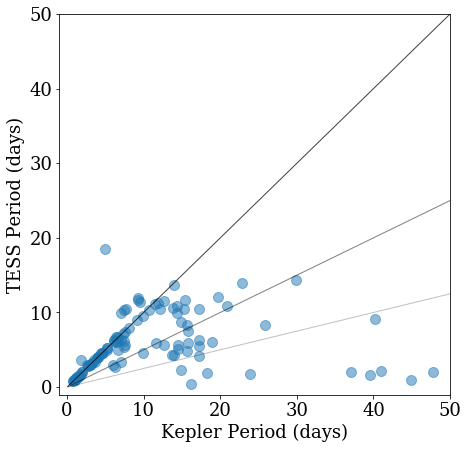

In [24]:
plt.figure(figsize=(7,7))

plt.scatter(Trot1['Period'][ok1], Trot1['acf_per'][ok1], alpha=0.5, c='C0', s=100)
plt.scatter(Trot2['Period'][ok2], Trot2['acf_per'][ok2], alpha=0.5, c='C0', s=100)

plt.plot([.1,50], [.1, 50], c='k', lw=1, alpha=0.75)
plt.plot([.1,50], [.05, 25], c='k', lw=1, alpha=0.5)
plt.plot([.1,50], [.025, 12.5], c='k', lw=1, alpha=0.25)
# plt.plot([.1,50], [.2, 100], c='k', lw=1, alpha=0.5)
# plt.plot([.1,50], [.4, 200], c='k', lw=1, alpha=0.25)

plt.xlim(-1,50)
plt.ylim(-1,50)

plt.xlabel('Kepler Period (days)')
plt.ylabel('TESS Period (days)')
plt.show()

# plt.figure(figsize=(7,7))

# plt.scatter(Trot1['Period'][ok1], Trot1['acf_per'][ok1]/Trot1['Period'][ok1], alpha=0.5, c='C0', s=100)
# plt.scatter(Trot2['Period'][ok2], Trot2['acf_per'][ok2]/Trot2['Period'][ok2], alpha=0.5, c='C0', s=100)

# plt.plot([.1,50], [1,1], c='k', lw=1, alpha=0.75)
# plt.plot([.1,50], [.5,.5], c='k', lw=1, alpha=0.5)
# plt.plot([.1,50], [.25, .25], c='k', lw=1, alpha=0.25)

# plt.xlim(-1,50)
# plt.ylim(0,1.1)

# plt.xlabel('Kepler Period (days)')
# plt.ylabel('TESS / Kepler Period')
# plt.show()


In [25]:
def ubin(data, nbins=10):
    '''
    return ranges that put even number of 
    samples into each bin
    '''
    num = int(np.around(np.size(data) / float(nbins), decimals=0)) # avg num per bin
    if num < 1:
        num = 1

    ss = np.argsort(data)
    bsplit = data[ss][np.arange(0, num*nbins, num)]
    bins = np.concatenate((bsplit, [np.nanmax(data)]))
    return bins

# Recovery Fraction

## ACF periods

In [26]:
# how close to the period do we need to be to be the "same"?
#      10% seems good
thresh = 0.1 

good = ((Trot1['acf_per'][ok1]/Trot1['Period'][ok1] > 1-thresh) & 
        (Trot1['acf_per'][ok1]/Trot1['Period'][ok1] < 1+thresh))
half = ((Trot1['acf_per'][ok1]/Trot1['Period'][ok1] > 0.5-thresh) & 
        (Trot1['acf_per'][ok1]/Trot1['Period'][ok1] < 0.5+thresh))

pbins = ubin(Trot1['Period'].values[ok1], nbins=10)
# pbins = np.logspace(-1.2, 1.8, num=20, dtype='float')
# pbins = np.arange(0, 55, 3., dtype='float')

pfrac = np.zeros_like(pbins)-1
hfrac = np.zeros_like(pbins)-1
e_pfrac = np.zeros((len(pbins), 2))-1
e_hfrac = np.zeros((len(pbins), 2))-1

for k in range(len(pbins)-1):
    
    pk = (Trot1['Period'].values[ok1] > pbins[k]) & (Trot1['Period'].values[ok1] <= (pbins[k+1]))
    den = float(sum(pk))
    num = float(sum(good[pk]))
    hal = float(sum(half[pk]))
    
    if den>0:
        pfrac[k] = num/den
        hfrac[k] = hal/den
        e_pfrac[k,:] = funcs.binom_conf_interval(num, den)
        e_hfrac[k,:] = funcs.binom_conf_interval(hal, den)

xx = ((pbins[:-1] + pbins[1:])/2)
# plt.figure()
# plt.plot(xx[np.where((pfrac > -1))], pfrac[np.where((pfrac > -1))], label='P')
# plt.plot(xx[np.where((hfrac > -1))], hfrac[np.where((hfrac > -1))], label='P/2')

# # plt.errorbar(xx[np.where((pfrac > -1))], pfrac[np.where((pfrac > -1))], 
# #              yerr = e_pfrac[np.where((pfrac > -1))[0], :].T, linestyle='none', c='C0')
# # plt.errorbar(xx[np.where((hfrac > -1))], hfrac[np.where((hfrac > -1))], 
# #              yerr = e_hfrac[np.where((hfrac > -1))[0], :].T, linestyle='none', c='C1')

# plt.legend(fontsize=12)
# plt.xscale('log')
# plt.xlabel('Kepler Period (days)')
# plt.ylabel('Fraction Recovered')

## L-S Periods

In [27]:
good = ((Trot1['LSper'][ok1]/Trot1['Period'][ok1] > 1-thresh) & 
        (Trot1['LSper'][ok1]/Trot1['Period'][ok1] < 1+thresh))
half = ((Trot1['LSper'][ok1]/Trot1['Period'][ok1] > 0.5-thresh) & 
        (Trot1['LSper'][ok1]/Trot1['Period'][ok1] < 0.5+thresh))

LSpfrac = np.zeros_like(pbins)-1
LShfrac = np.zeros_like(pbins)-1
LSe_pfrac = np.zeros((len(pbins), 2))-1
LSe_hfrac = np.zeros((len(pbins), 2))-1

for k in range(len(pbins)-1):
    pk = (Trot1['Period'].values[ok1] > pbins[k]) & (Trot1['Period'].values[ok1] <= (pbins[k+1]))
    den = float(sum(pk))
    num = float(sum(good[pk]))
    hal = float(sum(half[pk]))
    
    if den>0:
        LSpfrac[k] = num/den
        LShfrac[k] = hal/den
        LSe_pfrac[k,:] = funcs.binom_conf_interval(num, den)
        LSe_hfrac[k,:] = funcs.binom_conf_interval(hal, den)

# plt.figure()
# plt.plot(xx[np.where((LSpfrac > -1))], LSpfrac[np.where((LSpfrac > -1))], label='P')
# plt.plot(xx[np.where((LShfrac > -1))], LShfrac[np.where((LShfrac > -1))], label='P/2')

# plt.legend(fontsize=12)
# plt.xscale('log')
# plt.xlabel('Kepler Period (days)')
# plt.ylabel('Fraction Recovered')

Text(0, 0.5, 'Fraction Recovered')

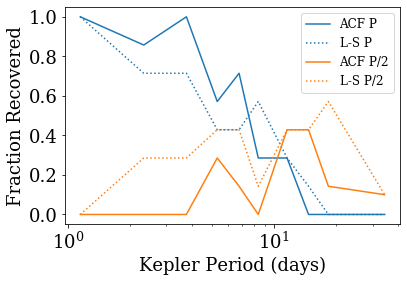

In [28]:
# plt.figure(figsize=(10,7))

plt.plot(xx[np.where((pfrac > -1))], pfrac[np.where((pfrac > -1))], label='ACF P', c='C0')
plt.plot(xx[np.where((LSpfrac > -1))], LSpfrac[np.where((LSpfrac > -1))], label='L-S P', c='C0', linestyle=':')

plt.plot(xx[np.where((hfrac > -1))], hfrac[np.where((hfrac > -1))], label='ACF P/2', c='C1')
plt.plot(xx[np.where((LShfrac > -1))], LShfrac[np.where((LShfrac > -1))], label='L-S P/2', c='C1', linestyle=':')

plt.legend(fontsize=12)
plt.xscale('log')
plt.xlabel('Kepler Period (days)')
plt.ylabel('Fraction Recovered')

# Reliability

Text(0, 0.5, 'Fraction Correct')

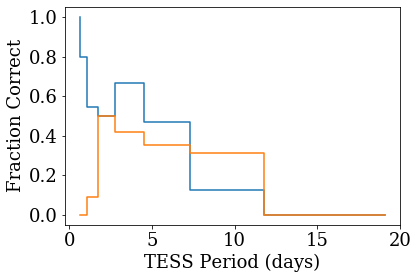

In [29]:
Rgood = ((Trot1['acf_per'][ok1]/Trot1['Period'][ok1] > 1-thresh) & 
         (Trot1['acf_per'][ok1]/Trot1['Period'][ok1] < 1+thresh))
Rhalf = ((Trot1['acf_per'][ok1]/Trot1['Period'][ok1] > 0.5-thresh) & 
         (Trot1['acf_per'][ok1]/Trot1['Period'][ok1] < 0.5+thresh))

# pbins = ubin(Trot1['acf_per'].values[ok1], nbins=5)
pbins = np.logspace(-.3, 2, num=12, dtype='float')
# pbins = np.arange(0, 55, 3., dtype='float')

Rpfrac = np.zeros_like(pbins)-1
Rphalf = np.zeros_like(pbins)-1
Re_pfrac = np.zeros((len(pbins), 2))-1
Re_phalf = np.zeros((len(pbins), 2))-1

for k in range(len(pbins)-1):
    pk = (Trot1['acf_per'].values[ok1] > pbins[k]) & (Trot1['acf_per'].values[ok1] <= (pbins[k+1]))
    den = float(sum(pk))
    num = float(sum(Rgood[pk]))
    hal = float(sum(half[pk]))

    if den>0:
        Rpfrac[k] = num/den
        Rphalf[k] = hal/den
        Re_pfrac[k,:] = funcs.binom_conf_interval(num, den)
        Re_phalf[k,:] = funcs.binom_conf_interval(hal, den)

pxx = ((pbins[:-1] + pbins[1:])/2)
plt.figure()
plt.step(pxx[np.where((Rpfrac > -1))], Rpfrac[np.where((Rpfrac > -1))])
plt.step(pxx[np.where((Rphalf > -1))], Rphalf[np.where((Rphalf > -1))])
plt.xlabel('TESS Period (days)')
plt.ylabel('Fraction Correct')

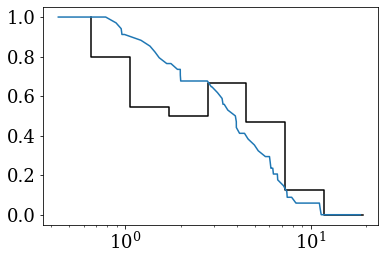

In [30]:
# TRY a continuous version, instead of bins (I did this before, but deleted it...)
TPsort = np.argsort(Trot1['acf_per'].values[ok1])[::-1]
Rcok = np.cumsum(Rgood.values[TPsort]) / np.sum(Rgood)#np.cumsum(np.arange(len(TPsort)))

plt.step(pxx[np.where((Rpfrac > -1))], Rpfrac[np.where((Rpfrac > -1))], c='k')
plt.plot(Trot1['acf_per'][ok1].values[TPsort], Rcok)
plt.xscale('log')

(0, 1)

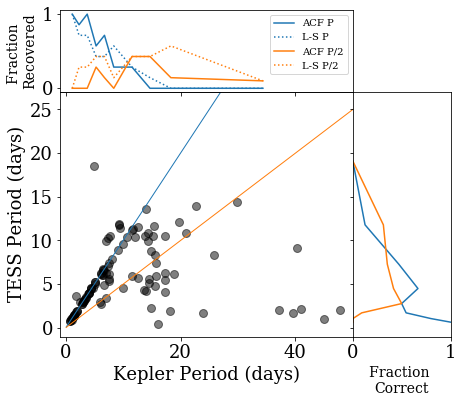

In [31]:
# Set up the axes with gridspec
fig = plt.figure(figsize=(7, 6))
grid = plt.GridSpec(4, 4, hspace=0., wspace=0.)
main_ax = fig.add_subplot(grid[1:,:-1])
y_hist = fig.add_subplot(grid[1:,-1], sharey=main_ax)
x_hist = fig.add_subplot(grid[0,:-1], sharex=main_ax)
x_hist.xaxis.set_tick_params(labelbottom=False)
y_hist.yaxis.set_tick_params(labelbottom=False)

# # scatter points on the main axes
main_ax.plot(Trot1['Period'][ok1], Trot1['acf_per'][ok1], alpha=0.5, c='k', 
             markersize=8, marker='o', linestyle='none',)
main_ax.plot(Trot2['Period'][ok2], Trot2['acf_per'][ok2], alpha=0.5, c='k', 
             markersize=8, marker='o', linestyle='none',)

# main_ax.set_xscale('log')
# main_ax.set_yscale('log')

main_ax.set_xlabel('Kepler Period (days)')
main_ax.set_ylabel('TESS Period (days)')
main_ax.set_xlim(-1,50)
main_ax.set_ylim(-1,27)

main_ax.plot([.1,50], [.1, 50], c='C0', lw=1)
main_ax.plot([.1,50], [.05, 25], c='C1', lw=1)

# Top hist
# x_hist.plot(xx[np.where((pfrac > -1))], pfrac[np.where((pfrac > -1))], c='C0')
x_hist.plot(xx[np.where((pfrac > -1))], pfrac[np.where((pfrac > -1))], label='ACF P', c='C0')
x_hist.plot(xx[np.where((LSpfrac > -1))], LSpfrac[np.where((LSpfrac > -1))], label='L-S P', c='C0', linestyle=':')
x_hist.plot(xx[np.where((hfrac > -1))], hfrac[np.where((hfrac > -1))], label='ACF P/2', c='C1')
x_hist.plot(xx[np.where((LShfrac > -1))], LShfrac[np.where((LShfrac > -1))], label='L-S P/2', c='C1', linestyle=':')

x_hist.set_ylabel('Fraction \nRecovered', fontsize=14)
x_hist.legend(fontsize=10)

# Right hist
y_hist.plot(Rpfrac[np.where((Rpfrac > -1))],pxx[np.where((Rpfrac > -1))])
y_hist.plot(Rphalf[np.where((Rphalf > -1))],pxx[np.where((Rphalf > -1))])

y_hist.set_xlabel('Fraction \nCorrect', fontsize=14)
y_hist.set_xlim(0,1)

# plt.savefig('KvT_0.20.png', dpi=150, bbox_inches='tight', pad_inches=0.25)

In [32]:
# Play with a guassian process
# RESULT: its not exactly what we're after, out of the box

Text(0.5, 0, '$t$')

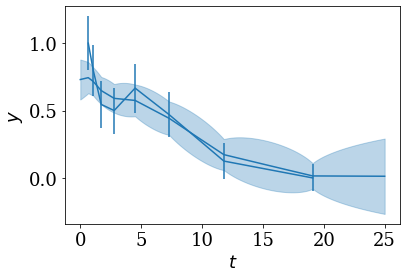

In [33]:
x = pxx[np.where((Rpfrac > -1))]
y = Rpfrac[np.where((Rpfrac > -1))]
t = np.linspace(0,25,500)

from scipy.optimize import minimize

import celerite
from celerite import terms

kernel = terms.RealTerm(log_a=np.log(1.5), log_c=-np.log(2.0))

gp = celerite.GP(kernel, fit_mean=False, mean=0)
# gp.compute(x, yerr)
yerr=np.sqrt(y)*.1+.1
gp.compute(x, yerr=yerr)

# Define a cost function
def neg_log_like(params, y, gp):
    gp.set_parameter_vector(params)
    return -gp.log_likelihood(y)

def grad_neg_log_like(params, y, gp):
    gp.set_parameter_vector(params)
    return -gp.grad_log_likelihood(y)[1]

# Fit for the maximum likelihood parameters
initial_params = gp.get_parameter_vector()
bounds = gp.get_parameter_bounds()
soln = minimize(neg_log_like, initial_params, jac=grad_neg_log_like,
                method="L-BFGS-B", bounds=bounds, args=(y, gp))
gp.set_parameter_vector(soln.x)

mu1, var1 = gp.predict(y, t, return_var=True)
std1 = np.sqrt(var1)

# Plot the data
color = "C0"
plt.errorbar(x, y, yerr=yerr, capsize=0)
plt.plot(t, mu1, color=color)
plt.fill_between(t, mu1+std1, mu1-std1, color=color, alpha=0.3, edgecolor="none")
plt.ylabel(r"$y$")
plt.xlabel(r"$t$")


(0.1, 25)

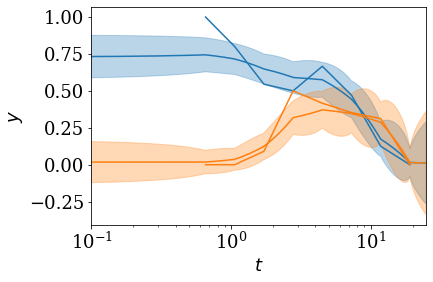

In [34]:
color = "C0"
plt.plot(x, y,color=color)
plt.plot(t, mu1, color=color)
plt.fill_between(t, mu1+std1, mu1-std1, color=color, alpha=0.3, edgecolor="none")
plt.ylabel(r"$y$")
plt.xlabel(r"$t$")

x2 = pxx[np.where((Rphalf > -1))]
y2 = Rphalf[np.where((Rphalf > -1))]
yerr2=np.sqrt(y2)*.1+.1
gp.compute(x2, yerr=yerr2)

# Fit for the maximum likelihood parameters
initial_params = gp.get_parameter_vector()
bounds = gp.get_parameter_bounds()
soln = minimize(neg_log_like, initial_params, jac=grad_neg_log_like,
                method="L-BFGS-B", bounds=bounds, args=(y, gp))
gp.set_parameter_vector(soln.x)

mu2, var2 = gp.predict(y2, t, return_var=True)
std2 = np.sqrt(var2)

color = "C1"
plt.plot(x2, y2, color=color)
plt.plot(t, mu2, color=color)
plt.fill_between(t, mu2+std2, mu2-std2, color=color, alpha=0.3, edgecolor="none")

plt.xscale('log')
plt.xlim(.1,25)

In [35]:
from scipy import special
from scipy.optimize import curve_fit

def ModifiedGaussian(t, A, mu, sigma, tau):
    '''
    # from Lupita's code
    '''
    x = 1./(2.*tau) * np.exp(.5*(sigma/tau)**2) * np.exp(- (t-mu)/tau)
    s = A*x*( 1. + special.erf((t-mu-sigma**2/tau)/np.sqrt(2*sigma**2)))
    return s

def ExpGaus(x, A, mu, sig, lam):
    '''
    https://en.wikipedia.org/wiki/Exponentially_modified_Gaussian_distribution
    '''
    f1 = lam/2 * (2*mu + lam*(sig**2) - 2*x)
    f2 = (mu + lam*sig**2 - x) / (np.sqrt(2)*sig)
    f = A * lam/2 * np.exp(f1) * special.erfc(f2)
    return f


Text(0, 0.5, 'Fraction Correct')

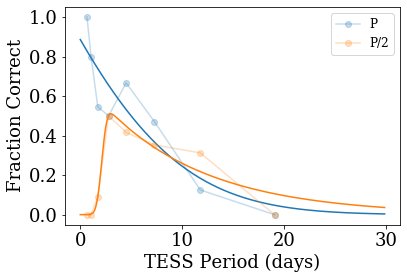

In [36]:
# p0 = [5, 4, 2, 3]
p0 = [8, 1, 2, .1]


popt1, pcov1 = curve_fit(ExpGaus, pxx[np.where((Rpfrac > -1))], Rpfrac[np.where((Rpfrac > -1))], 
                         p0=p0, sigma=0.5*np.ones_like(Rpfrac[np.where((Rpfrac > -1))]))
popt2, pcov2 = curve_fit(ExpGaus, pxx[np.where((Rphalf > -1))], Rphalf[np.where((Rphalf > -1))], 
                         p0=p0, sigma=0.5*np.ones_like(Rphalf[np.where((Rphalf > -1))]))

plt.figure()
plt.plot(pxx[np.where((Rpfrac > -1))], Rpfrac[np.where((Rpfrac > -1))], '-o', label='P', c='C0',alpha=0.25)
plt.plot(np.arange(0,30,0.1), ExpGaus(np.arange(0,30,0.1),*popt1))

plt.plot(pxx[np.where((Rphalf > -1))], Rphalf[np.where((Rphalf > -1))], '-o', label='P/2', c='C1',alpha=0.25)
plt.plot(np.arange(0,30,0.1), ExpGaus(np.arange(0,30,0.1),*popt2))

plt.legend(fontsize=12)
# plt.xscale('log')
plt.xlabel('TESS Period (days)')
plt.ylabel('Fraction Correct')

(-0.1, 1)

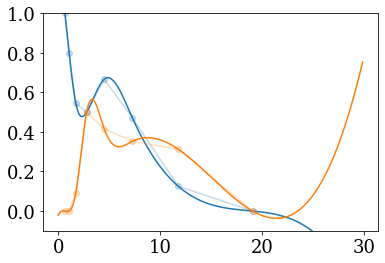

In [37]:
# lets try cubic splines... NOPE
from scipy.interpolate import CubicSpline, Akima1DInterpolator

cs1 = CubicSpline(pxx[np.where((Rpfrac > -1))], Rpfrac[np.where((Rpfrac > -1))])
ak1 = Akima1DInterpolator(pxx[np.where((Rpfrac > -1))], Rpfrac[np.where((Rpfrac > -1))])

plt.plot(pxx[np.where((Rpfrac > -1))], Rpfrac[np.where((Rpfrac > -1))], '-o', label='P', c='C0',alpha=0.25)
plt.plot(np.arange(0,30,0.1), cs1(np.arange(0,30,0.1)))
# plt.plot(np.arange(0,30,0.1), ak1(np.arange(0,30,0.1)))

cs2 = CubicSpline(pxx[np.where((Rphalf > -1))], Rphalf[np.where((Rphalf > -1))])
plt.plot(pxx[np.where((Rphalf > -1))], Rphalf[np.where((Rphalf > -1))], '-o', label='P/2', c='C1',alpha=0.25)
plt.plot(np.arange(0,30,0.1), cs2(np.arange(0,30,0.1)))
plt.ylim(-.1,1)

In [38]:
# # spit out TICs for short period contaminents for Keaton
# fK = np.where((Trot1['Period'][ok1] > 10) & (Trot1['acf_per'][ok1]< 4))[0]
# print(np.shape(fK))

# for k in range(len(fK)):
#     print(Trot1['TIC'][ok1].values[fK][k], 
#           format(Trot1['Period'][ok1].values[fK][k], '10.5f'),
#           format(Trot1['acf_per'][ok1].values[fK][k], '10.5f') )

74


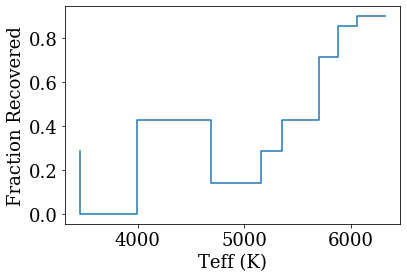

In [39]:
# TESS recovery as a function of Teff

# Tbins = np.concatenate(([2800, 3500], np.arange(4500,7500,150, dtype='float')))
Tbins = ubin(Trot1['Teff'].values[ok1], nbins=10)
Tfrac = np.zeros_like(Tbins, dtype='float')-1

for k in range(len(Tbins)-1):
    pk = (Trot1['Teff'].values[ok1] > Tbins[k]) & (Trot1['Teff'].values[ok1] <= (Tbins[k+1]))
    den = float(sum(pk))
    num = float(sum(Rgood[pk]))
    
    if den>0:
        Tfrac[k] = num/den

Tx = ((Tbins[:-1] + Tbins[1:])/2)

plt.figure()
plt.step(Tx[np.where((Tfrac > -1))], Tfrac[np.where((Tfrac > -1))])
plt.xlabel('Teff (K)')
plt.ylabel('Fraction Recovered')

print(len(Rgood))

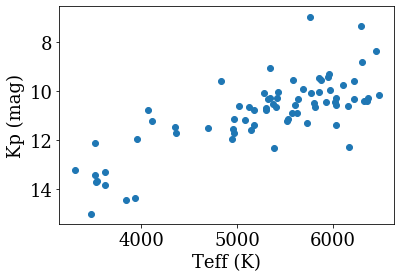

In [40]:
plt.scatter(Trot1['Teff'].values[ok1], Trot1['kepmag'].values[ok1])
plt.xlabel('Teff (K)')
plt.ylabel('Kp (mag)')
plt.gca().invert_yaxis()

Text(0, 0.5, 'Fraction Recovered')

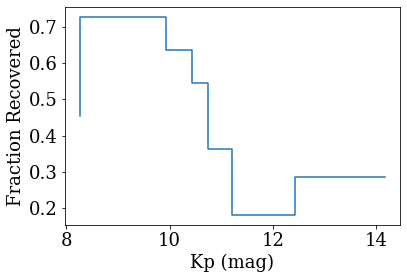

In [41]:
# TESS recovery as a function of Teff
Kbins = ubin(Trot1['kepmag'].values[ok1], nbins=7)

Kfrac = np.zeros_like(Kbins, dtype='float')-1

for k in range(len(Kbins)-1):
    pk = (Trot1['kepmag'].values[ok1] > Kbins[k]) & (Trot1['kepmag'].values[ok1] <= (Kbins[k+1]))
    den = float(sum(pk))
    num = float(sum(Rgood[pk]))
    
    if den>0:
        Kfrac[k] = num/den

Kx = ((Kbins[:-1] + Kbins[1:])/2)

plt.figure()
plt.step(Kx[np.where((Kfrac > -1))], Kfrac[np.where((Kfrac > -1))])
plt.xlabel('Kp (mag)')
plt.ylabel('Fraction Recovered')